In [1]:
# show C-level stderr/stdout
%load_ext lab_black
%load_ext wurlitzer
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

In [3]:
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from nuq import NuqRegressor

plt.rcParams.update({"font.size": 14})

In [4]:
import ray

# Compare with different parallelism
ray.init()
# ray.init(num_cpus=1)
# ray.init(num_cpus=4)

2022-02-02 03:26:46,508	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8266


{'node_ip_address': '10.1.16.11',
 'raylet_ip_address': '10.1.16.11',
 'redis_address': '10.1.16.11:26995',
 'object_store_address': '/tmp/ray/session_2022-02-02_03-26-44_713903_2832172/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-02-02_03-26-44_713903_2832172/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2022-02-02_03-26-44_713903_2832172',
 'metrics_export_port': 65466,
 'node_id': '277dd15293adcbc5a452ed41ac3d8e156b63a63bbe47f21dd0fbd9bc'}

In [11]:
# Number of points
N = 50000
# Dimensonality
d = 50
tune_bandwidth = "regression:n_folds=10;n_samples=3;verbose=1"

X = np.random.uniform(size=(N, d))
y = np.random.uniform(size=N)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"{X_train.shape = }, {X_val.shape = }")

nuq = NuqRegressor(n_neighbors=20, tune_bandwidth=tune_bandwidth, verbose=True)
_ = nuq.fit(X_train, y_train, np.random.exponential(1, X_train.shape[0])[:, None])

X_train.shape = (40000, 50), X_val.shape = (10000, 50)


Tuning bandwidth:   0%|          | 0/3 [00:00<?, ?it/s]

  [REGRESSION:N_FOLDS=10;N_SAMPLES=3;VERBOSE=1] bandwidth = 3.62142276763916 (score = -0.03871732281961471)


In [6]:
%%timeit

pred = nuq.predict(X_val, return_uncertainty="aleatoric")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

699 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Parallelism Comparison

1 core: `1.5 s ± 125 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

vs

4 cores: `699 ms ± 138 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)`

## Inference on Toy Dataset

In [5]:
def make_regression(total_size=200, a=0.0, b=1.0, eps=(2e-2, 2e-1), return_f=False):
    xs = np.linspace(a, b, total_size)
    f = lambda x: np.sin(10 * x) + np.sin(20 * x)
    X = xs + eps[0] * np.random.randn(total_size)
    y = f(xs) + eps[1] * np.random.randn(total_size)

    if return_f:
        return X.reshape(-1, 1), y, f
    else:
        return X.reshape(-1, 1), y

  [ISJ] bandwidth = array([0.01366292])


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  [REGRESSION] bandwidth = 0.05427393717682564 (score = 0.5893873421110016)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

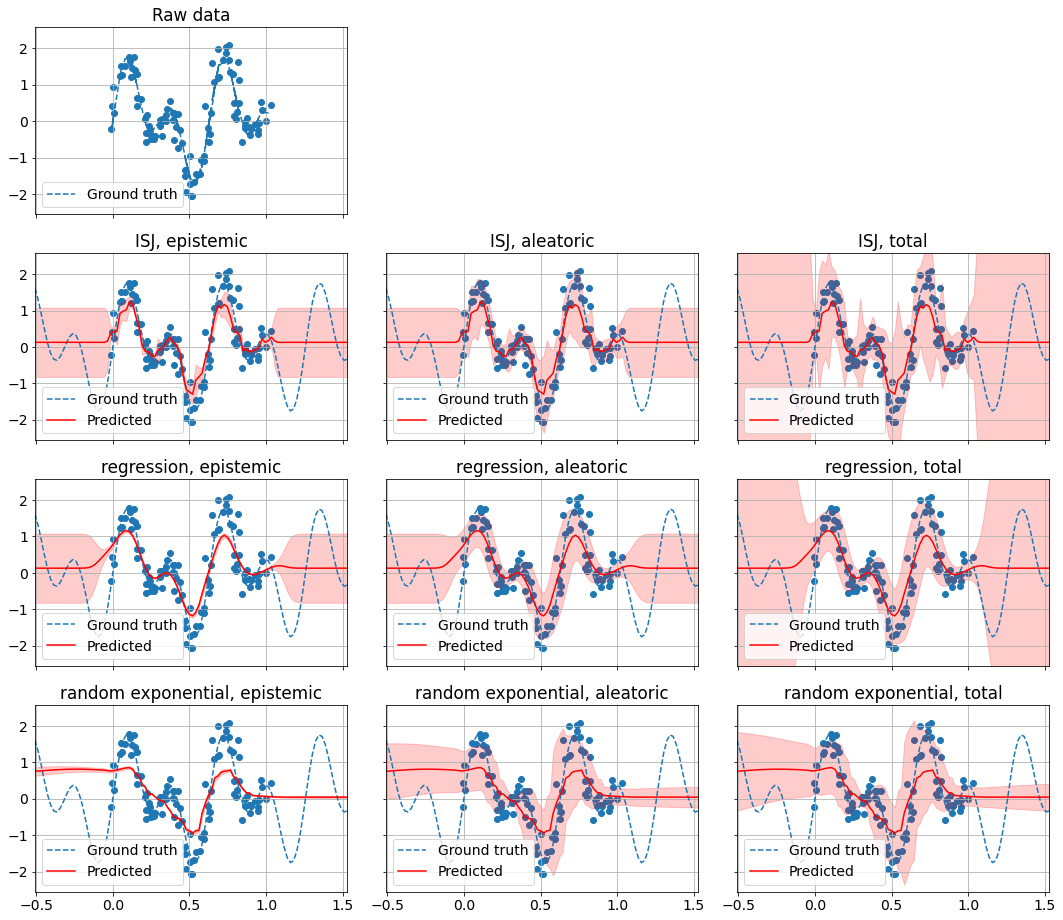

In [10]:
## Make a dataset
X, y, f_reg = make_regression(total_size=100, return_f=True)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

n_points = 100
h = 0.1
x_min, x_max = X.min() - 5 * h, X.max() + 5 * h
y_min, y_max = y.min() - 5 * h, y.max() + 5 * h
X_test = np.linspace(x_min, x_max, num=n_points).reshape(-1, 1)

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 13), sharey=True, sharex=True)
ax = ax.ravel()

ax[0].set_title("Raw data")
ax[0].plot(X, f_reg(X), "--", label="Ground truth")
ax[0].scatter(X, y)
ax[0].set_xlim(x_min, x_max)
ax[0].set_ylim(y_min, y_max)
ax[0].grid()
ax[0].legend()

ax[1].axis("off")
ax[2].axis("off")


bandwidth_rand = np.random.exponential(0.5, X_train.shape[0])[:, None]
fixed = "random exponential"
for i, tune_bandwidth in enumerate(["ISJ", "regression", fixed]):
    nuq = NuqRegressor(
        tune_bandwidth=tune_bandwidth.lower() if tune_bandwidth != fixed else None,
        kernel_type="RBF",
        n_neighbors=20,
        log_pN=0.0,
        verbose=True,
    )

    nuq.fit(
        X=X_train,
        y=y_train,
        bandwidth=bandwidth_rand if tune_bandwidth == fixed else None,
    )

    first_run = True
    for j, return_uncertainty in enumerate(["epistemic", "aleatoric", "total"]):
        idx = 3 * (i + 1)

        y_pr, log_uncertainty = nuq.predict(
            X_test, return_uncertainty=return_uncertainty
        )

        ax[idx + j].set_title(f"{tune_bandwidth}, {return_uncertainty}")
        ax[idx + j].scatter(X, y)
        ax[idx + j].set_xlim(x_min, x_max)
        ax[idx + j].set_ylim(y_min, y_max)
        ax[idx + j].plot(X_test, f_reg(X_test), "--", label="Ground truth")
        ax[idx + j].plot(X_test, y_pr, color="r", label="Predicted")
        uncertainty = np.exp(log_uncertainty)
        ax[idx + j].fill_between(
            X_test.ravel(), y_pr - uncertainty, y_pr + uncertainty, alpha=0.2, color="r"
        )
        ax[idx + j].grid()
        ax[idx + j].legend()

plt.tight_layout()
plt.show()

In [8]:
fig.savefig("nuq_regression.pdf")